In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content/drive/My Drive/covid_image_classifier_extra_data

/content/drive/My Drive/covid_image_classifier_extra_data


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50V2, DenseNet121
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, f1_score, precision_score, recall_score, classification_report
from datetime import datetime
import pickle as pkl

tf.random.set_seed(51)

# Load and preprocess data

In [3]:
def to_one_hot(y):
  if y == 'covid':
    return np.array([1, 0, 0])
  elif y == 'normal':
    return np.array([0, 1, 0])
  elif y == 'pneumonia':
    return np.array([0, 0, 1])
  else:
    raise ValueError(y + ' does not belong to any class')

In [11]:
def load_from_path(path):

  # Load and preprocess train data
  data = []
  labels = []

  for folder in os.listdir(path):
    for img in tqdm(os.listdir(os.path.join(path, folder)), position=0, leave=True):
      try:
        # read, convert channels, and resize images
        image = cv2.imread(os.path.join(path, folder, img))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        # Extract labels
        label = folder

        # Append to lists
        data.append(image)
        labels.append(label)
      except:
        print('\n', folder, img)

  # Convert to numpy array and normalize images
  x = np.array(data)/255.
  y = np.array(labels)
  print('Shape of X = %s\nShape of y = %s' % (str(x.shape), str(y.shape)))

  # convert y to one-hot
  y_one_hot = np.array([to_one_hot(lab) for lab in y])
  print('Shape of y(onehot) = %s' % str(y_one_hot.shape))

  return x, y, y_one_hot

In [30]:
def save_as_pickle(data, filename):
  if filename[-4:] != '.pkl':
    filename = filename + '.pkl'
    print(filename)

  with open(filename, 'wb') as file:
    pkl.dump(data, file)

In [5]:
def load_pickle(filename):
  if filename[-4:] != '.pkl':
    filename = filename + '.pkl'

  with open(filename, 'rb') as file:
    data = pkl.load(file)

  return data

In [ ]:
# Load train and validation datasets
x_train, y_train, y_train_one_hot = load_from_path('data/train')
x_val, y_val, y_val_one_hot = load_from_path('data/test')

In [ ]:
# In case x_train exceeds 4 GB
x_train_1 = x_train[:int(x_train.shape[0]/2),:,:,:]
x_train_2 = x_train[int(x_train.shape[0]/2):,:,:,:]
print(x_train_1.shape, x_train_2.shape)

In [31]:
# Save as pickles
save_as_pickle(x_train_1, 'x_train_1.pkl')
save_as_pickle(x_train_2, 'x_train_2.pkl')
save_as_pickle(y_train, 'y_train.pkl')
save_as_pickle(y_train_one_hot, 'y_train_one_hot.pkl')

save_as_pickle(x_val, 'x_val.pkl')
save_as_pickle(y_val, 'y_val.pkl')
save_as_pickle(y_val_one_hot, 'y_val_one_hot.pkl')

In [6]:
# Load pickles
x_train_1 = load_pickle('x_train_1.pkl')
x_train_2 = load_pickle('x_train_2.pkl')
y_train = load_pickle('y_train.pkl')
y_train_one_hot = load_pickle('y_train_one_hot.pkl')

x_val = load_pickle('x_val.pkl')
y_val = load_pickle('y_val.pkl')
y_val_one_hot = load_pickle('y_val_one_hot.pkl')

In [ ]:
# Combine x_train_1 and x_train_2
x_train = np.concatenate((x_train_1, x_train_2), axis=0)
print(x_train.shape)

In [6]:
# Overwrite x_train_1 and x_train_2 with 0 to clear memory
x_train_1 = 0
x_train_2 = 0

# Model
- VGG 16
- ResNet50V2
- DenseNet121

In [8]:
def create_pretrained_model(model_name='resnetv2'):
  
  if model_name == 'resnetv2':
    return ResNet50V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
  elif model_name == 'densenet121':
    return DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
  elif model_name == 'vgg16':
    return VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
  else:
    raise ValueError('Please specify model_name ["resnetv2", "densenet121", "vgg16"]')

In [15]:
def create_model(model_name):
  '''
  Creates model for transfer learning from pretrained model.

  Arguments:
  model_name -- Name of pretrained models which include "resnetv2", "densenet121", "vgg16".

  Returns:
  model -- a model instance in Keras for transfer learning.
  '''

  # Load pretrained model and freeze it
  pretrained_model = create_pretrained_model(model_name)
  pretrained_model.trainable = False

  # construct the head of the model that will be placed on top of the the base model
  x = GlobalAveragePooling2D()(pretrained_model.output)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

  x = Dense(256)(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)
  x = Dense(3, activation="softmax")(x)

  # place the head FC model on top of the base model (this will become the actual model we will train)
  model = Model(inputs=pretrained_model.input, outputs=x)
  print(model.summary())

  return model

In [10]:
model = create_model('resnetv2')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
def create_deep_model(model_name):
  '''
  Creates deep model for transfer learning from pretrained model.
  '''

  # Load pretrained model and freeze it
  pretrained_model = create_pretrained_model(model_name)
  pretrained_model.trainable = False

  # construct the head of the model that will be placed on top of the the base model
  x = GlobalAveragePooling2D()(pretrained_model.output)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

  x = Dense(1024)(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)

  x = Dense(512)(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)

  x = Dense(256)(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)

  x = Dense(128)(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)

  x = Dense(64)(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)

  x = Dense(3, activation="softmax")(x)

  # place the head FC model on top of the base model (this will become the actual model we will train)
  model = Model(inputs=pretrained_model.input, outputs=x)
  print(model.summary())

  return model

# Train

- Set hyperparameters
- Compile
- Create callbacks to save only the best checkpoint
- Augment data
- Train

In [ ]:
# Set hyperparameters
initial_lr = 3e-4
epochs = 25
batch_size = 16
decay_rate = 0.95
decay_step = 1

# Compile model
opt = Adam(lr=initial_lr)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC()])

# Save only the best checkpoint
time = datetime.now().strftime('_%H-%M-%S')
checkpoint_filepath_best = 'resnet50_batchnorm_first_checkpoints_best'+time+'/'
os.mkdir(checkpoint_filepath_best)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_best,
    save_weights_only=False,
    monitor='val_accuracy',# val_auc_4 val_accuracy
    mode='max',
    save_best_only=True)

# Learning rate decay
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : initial_lr * (decay_rate**int(epoch / decay_step)))

# Train the head of the network with image augmentation
train_generator = ImageDataGenerator(rotation_range=60, fill_mode="nearest", horizontal_flip=True, vertical_flip=True)

history = model.fit_generator(train_generator.flow(x_train, y_train_one_hot, batch_size=batch_size),
                              steps_per_epoch=len(x_train) // batch_size,
                              validation_data=(x_val, y_val_one_hot),
                              validation_steps=len(y_train_one_hot) // batch_size,
                              epochs=epochs,
                              callbacks=[model_checkpoint_callback, lr_schedule]) # class_weight={0:1, 1:1, 2:1}

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
227/227 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.7482 - auc: 0.9000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 227 batches). You may need to use the repeat() function when building your dataset.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_batchnorm_first_checkpoints_best_05-32-33/assets
227/227 [==============================] - 65s 288ms/step - loss: 0.6304 - accuracy: 0.7482 - auc: 0.9000 - val_loss: 0.4998 - val_accuracy: 0.7778 - val_auc: 0.9312 - lr: 3.0000e-04
Epoch 2/25
227/227 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.8192 - auc: 0.9442WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure th

In [ ]:
# Plot and save training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(checkpoint_filepath_best+'training_graph.jpg')
plt.show()

# Benchmark
Focus mainly on F1-score

In [7]:
def benchmark(model, save_path, x_val, y_val_one_hot):
  # Create prediction
  predictions = model.predict(x_val)

  # Create Confusion Matrix
  cm = confusion_matrix(np.argmax(y_val_one_hot, axis=1), np.argmax(predictions, axis=1))

  # Plot Confusion Matrix
  plot_confusion_matrix(cm, normalize=False, target_names=['covid', 'normal', 'pneumonia'], title="Confusion Matrix", path=save_path)

  # Print classification_report
  report = classification_report(np.argmax(y_val_one_hot, axis=1), np.argmax(predictions, axis=1), target_names=['covid','normal','pneumonia'], output_dict=True)
  avg_f1 = (report['covid']['f1-score'] + report['normal']['f1-score'] + report['pneumonia']['f1-score']) / 3
  avg_acc = report['accuracy']
  print(classification_report(np.argmax(y_val_one_hot, axis=1), np.argmax(predictions, axis=1), target_names=['covid','normal','pneumonia']))
  print('Average F1-Score =', avg_f1)

  # Save avg_f1 and avg_acc to txt file
  with open(save_path+'benchmark.txt', 'w') as file:
    file.write('Average F1-Score: %.4f\nAverage Accuracy: %.4f' % (avg_f1, avg_acc))
    file.write(str(report))


In [8]:
def plot_confusion_matrix(cm, target_names, path, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(path+'confusion_matrix.png')
    plt.show()

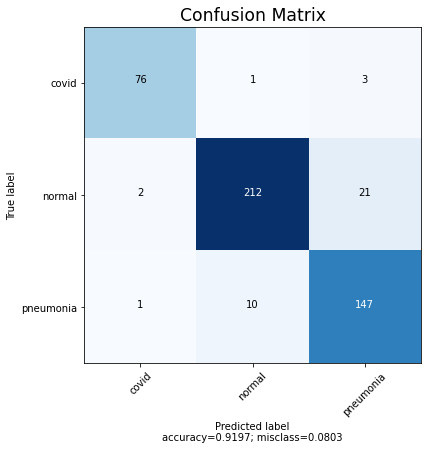

              precision    recall  f1-score   support

       covid       0.96      0.95      0.96        80
      normal       0.95      0.90      0.93       235
   pneumonia       0.86      0.93      0.89       158

    accuracy                           0.92       473
   macro avg       0.92      0.93      0.93       473
weighted avg       0.92      0.92      0.92       473

Average F1-Score = 0.9251186853945429


In [35]:
# Benchmark the model
benchmark(tf.keras.models.load_model(checkpoint_filepath_best), save_path='', x_val=x_val, y_val_one_hot=y_val_one_hot)

# Resources

## - Train flow from directories
Super slow because it streams data from google drive. To solve this, get data from google drive onto this instances which also takes too much time.

In [ ]:
train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15,
                    # width_shift_range=.15,
                    # height_shift_range=.15,
                    #horizontal_flip=True,
                    #vertical_flip=True,
                    # zoom_range=0.5,
                    fill_mode='nearest' #'reflect'
                    )

validation_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    # rotation_range=45,
                    # horizontal_flip=True,
                    ) # Generator for our validation data

# Set hyperparameter
batch_size = 16
epochs = 30
IMG_HEIGHT = 224
IMG_WIDTH = 224
train_dir = 'data/train'
validation_dir = 'data/test'

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           color_mode="rgb")

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              color_mode="rgb")

# Set hyperparameters
initial_lr = 1e-3
decay_rate = 0.3

# compile our model
opt = Adam(lr=initial_lr)#, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC()])

# Save only best checkpoints
time = datetime.now().strftime('_%H-%M-%S')

checkpoint_filepath_best = 'resnet50_all_checkpoints_best'+time+'/'
os.mkdir(checkpoint_filepath_best)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_best,
    save_weights_only=False,
    monitor='val_accuracy',# val_auc_4 val_accuracy
    mode='max',
    save_best_only=True)

# Learning rate decay
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: initial_lr/(1+decay_rate*epoch))

# Train
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=[model_checkpoint_callback, lr_schedule]
)